## Using Fastai Data Block API together with PyTorch and Keras Training

This notebook explores possibility of using fastai data block and augmentation API, and use Keras to do all the rest. This is an experiment to try and mix/match the 2 frameworks. This assumes you have good familiarity with either frameworks.

**Why do this?**

Just to see how it will work. If you have already a custom Keras model, loss, and metrics and whole bunch of neat tricks done and thoroughly debugged, you may not ready to do a full rewrite. But you come across some a new dataset and a couple of neat data augmentations in fastai that you want to use, you can quickly test your idea out.

Given this is a small experiment and may not scale, you have to extrapolate to your case at your own risk. It could be ok if you want to test out something quick, or for debugging, but it may be inefficient.



Prerequisites:

* Python 3.6 or above

Recommended:
* fastai 1.0.42 
* keras 2.2.4

#### Import

In [33]:
from pathlib import *
from six.moves import urllib

from fastai.vision import *
from fastai.collab import *
from fastai.tabular import *
from fastai.metrics import error_rate

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils

from PIL import Image
import numpy 
import numpy as np
import os

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Common utils

In [2]:
def _describe(self):
    print(f"shape: {self.shape}")
    print(f"dtyle: {self.dtype}")
    print(f"min_val: {torch.min(self)}")
    print(f"max_val: {torch.max(self)}")
    print(f"type: {type(self)}")

torch.Tensor.describe = _describe

# can't monkey patch numpy.array, don't hack too much, so do this instead:
def np_desc(a):
    if isinstance(a, (np.ndarray)):
        print(f"shape: {a.shape}")
        print(f"dtyle: {a.dtype}")
        
        print(f"content: {a}")    # this is ok, it is truncated nicely.
        print(f"type: {type(a)}")
    else:
        print("Not a numpy.ndarray")
        
# def ():
#     (x.numpy()*255.).astype(np.uint8).transpose((1, 2, 0))

#### Prepare data

In [3]:
# Use MNIST sample
path = untar_data(URLs.MNIST); path.ls()

[PosixPath('/Users/kelvinchan/.fastai/data/mnist_png/training'),
 PosixPath('/Users/kelvinchan/.fastai/data/mnist_png/testing')]

In [12]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, train='training', ds_tfms=tfms, size=32)

/Users/kelvinchan/tmp/python3_env/deeplearning/lib/python3.7/site-packages/fastai/data_block.py:411: UserWarning: Your validation set is empty. Is this is by design, use `no_split()` 
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


In [ ]:
#     y = (x.numpy()*255.).astype(np.uint8).transpose((1, 2, 0))
#     img = PIL.Image.fromarray(y)
#     img = img.filter(ImageFilter.GaussianBlur(radius=radius))
#     x = np.array(img).transpose((2, 0, 1))
    
#     return torch.tensor(x/255., dtype=torch.float32)

# type(x.numpy().transpose((0, 2, 3, 1)))

#### Know Thy training set

In [13]:
# take a quick look at X, and Y mini-batches
for (k, (x, y)) in enumerate(data.train_dl):
    print(f"batch: {k}")
    print("-----------")
    print("X:")
    x.describe()
    print("Y:")
    y.describe()
    print("====================================")
    if k > 0: break

batch: 0
-----------
X:
shape: torch.Size([64, 3, 32, 32])
dtyle: torch.float32
min_val: 0.0
max_val: 1.0
type: <class 'torch.Tensor'>
Y:
shape: torch.Size([64])
dtyle: torch.int64
min_val: 0
max_val: 9
type: <class 'torch.Tensor'>
batch: 1
-----------
X:
shape: torch.Size([64, 3, 32, 32])
dtyle: torch.float32
min_val: 0.0
max_val: 1.0
type: <class 'torch.Tensor'>
Y:
shape: torch.Size([64])
dtyle: torch.int64
min_val: 0
max_val: 9
type: <class 'torch.Tensor'>


**Note**: 

* Batch size is 64
* Image size is 32x32
* X is channel first (being torch tensor) and normalized between 0. and 1. 
* Y is of type Int64
* Y is **NOT** one-hot encoded as max_val is 9 and shape is [64]
* Visualize X by plt.imshow(...)


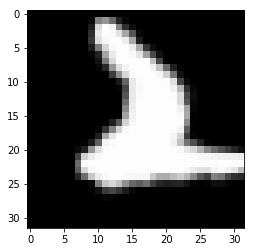

In [14]:
plt.imshow((x[0].numpy()*255.).astype(np.uint8).transpose((1, 2, 0)))

#### PyTorch training
The following code mostly borrowed from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()    

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [16]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for (k, (X, Y)) in enumerate(data.train_dl, 0):
        # get the inputs
#         inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if k % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, k + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/local/Cellar/python/3.7.1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/local/Cellar/python/3.7.1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/local/Cellar/python/3.7.1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

In [17]:
# plt.imshow((images[1].numpy()).astype(np.uint8).transpose((1, 2, 0)))

In [18]:
from torch.nn import functional as F

In [23]:
x_to_be_blur = x[0]; x_to_be_blur.shape

torch.Size([3, 32, 32])

#### Keras training

In [37]:
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=(26, 26, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))                
model.add(Dropout(rate=0.5))
model.add(Dense(10, activation='softmax'))

In [ ]:
model.summary(), model.input, model.output